# Stock Market Prediction using CNN-LSTM model
This project is about analysis of Stock Market and providing predictions to the stockholders. 

For this, we used CNN-LSTM approach to create a blank model, then use it to train on stock market data. Further implementation is discussed below...

# Data collect

Before preprocessing data, a function to fetch real-time stock data (using Alpha Vantage API) is made

In [63]:

key = "TV1WC9ANR799K1H1"

import requests
import csv
from tqdm import tqdm

def request_stock_price_list(symbol, size, token):
    q_string = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={}&outputsize={}&apikey={}'
    
    print("Retrieving stock price data from Alpha Vantage (This may take a while)...")
    r = requests.get(q_string.format(symbol, size, token))
    print("Data has been successfully downloaded...")
    date = []
    colnames = list(range(0, 5))
    df = pd.DataFrame(columns = colnames)
    print("Sorting the retrieved data into a dataframe...")
    for i in tqdm(r.json()['Time Series (Daily)'].keys()):
        date.append(i)
        row = pd.DataFrame.from_dict(r.json()['Time Series (Daily)'][i], orient='index').reset_index().T[1:]
        df = pd.concat([df, row], ignore_index=True)
    df.columns = ["Open", "High", "Low", "Close", "Volume"]
    df['Date'] = date
    return df

In [64]:
# UNCOMMENT THE CELL IF DATA IS NEEDED TO BE LOADED FOR 1ST TIME

# cv1 = request_stock_price_list('IBM', 'full', key)
# print(cv1.head)
# cv1.to_csv('./data/data.csv')

# Training part

This part has 2 subparts: CNN and LSTM

For CNN, the layers are created with sizes 64,128,64 with kernel size = 3. In every layer, TimeDistributed function is added to track the features for every temporal slice of data with respect to time. In between, MaxPooling layers are added.

After that, it's passed to Bi-LSTM layers

In [79]:
# For creating model and training
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import datetime as dt
from datetime import datetime    
sns.set_style("whitegrid")
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")


# 封装
class StockPredictor:
    def __init__(self,data_path,window_size=100):
        self.data_path = data_path      # 数据路径
        
        self.window_size = window_size    # 窗口大小
        self.train_X,self.test_X,self.train_Y,self.test_Y = self.__pressing_data(self.data_path)  # 第一步：数据预处理
        self.model = self.__construct_model()                                            # 第二步：模型
        self.history = None                                                       
        
    
    def __pressing_data(self,data_path,shuffle=True):
        window_size = self.window_size
        data = pd.read_csv(data_path, usecols=["Close"])
        data.reset_index(drop=True, inplace=True)
        data.fillna(data.mean(), inplace=True)

        close_column = data['Close']
        X = []
        Y = []
        for i in range(1 , len(close_column) - window_size -1 , 1):
            first = close_column[i]
            temp = []
            temp2 = []
            for j in range(window_size):
                temp.append((close_column[i + j] - first) / first)
            temp2.append((close_column[i + window_size] - first) / first)
            X.append(np.array(temp).reshape(100, 1))
            Y.append(np.array(temp2).reshape(1, 1))

        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=shuffle)

        train_X = np.array(x_train)
        test_X = np.array(x_test)
        train_Y = np.array(y_train)
        test_Y = np.array(y_test)
        train_X = train_X.reshape(train_X.shape[0],1,100,1)
        test_X = test_X.reshape(test_X.shape[0],1,100,1)
        return train_X, test_X, train_Y, test_Y

    
    def __construct_model(self, dropout=0.5):
        window_size = self.window_size
        model = tf.keras.Sequential()
        # Creating the Neural Network model here...
        # CNN layers
        model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu', input_shape=(None, window_size, 1))))
        model.add(TimeDistributed(MaxPooling1D(2)))
        model.add(TimeDistributed(Conv1D(128, kernel_size=3, activation='relu')))
        model.add(TimeDistributed(MaxPooling1D(2)))
        model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu')))
        model.add(TimeDistributed(MaxPooling1D(2)))
        model.add(TimeDistributed(Flatten()))
        # model.add(Dense(5, kernel_regularizer=L2(0.01)))
        # LSTM layers
        model.add(Bidirectional(LSTM(100, return_sequences=True)))
        model.add(Dropout(dropout))
        model.add(Bidirectional(LSTM(100, return_sequences=False)))
        model.add(Dropout(dropout))
        #Final layers
        model.add(Dense(1, activation='linear'))
        model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
        return model

    def fit(self, epochs=40, batch_size=40, verbose=1, shuffle=True):
        # 训练模型
        self.history = self.model.fit(self.train_X, self.train_Y, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle=shuffle, validation_data=(self.test_X, self.test_Y))
        
    
    def plot(self):
        # 绘制训练过程
        plt.figure(figsize=(10, 6))
        plt.plot(self.history.history['mse'], label='train mse')
        plt.plot(self.history.history['val_mse'], label='val mse')
        plt.xlabel("epoch")
        plt.ylabel("MSE")
        plt.legend()
        plt.show()
        plt.figure(figsize=(10, 6))
        plt.plot(self.history.history['mae'], label='train mae')
        plt.plot(self.history.history['val_mae'], label='val mae')
        plt.xlabel("epoch")
        plt.ylabel("MAE")
        plt.legend()
        plt.show()
        
    def summary(self):
        self.model.summary()
    
    def evaluate(self):
        return self.model.evaluate(self.test_X, self.test_Y)

    def __predict_handle(self,data_path,train_X,test_X,test_Y):
        predicted_pre  = self.model.predict(test_X)   # 预测
        test_label_pre = test_Y.reshape(-1,1)       # 真实值
        predicted_pre = np.array(predicted_pre[:,0]).reshape(-1,1)
        
        close_column = pd.read_csv(data_path, usecols=["Close"])
        close_column.reset_index(drop=True, inplace=True)
        close_column.fillna(close_column.mean(), inplace=True)
        close_column = close_column['Close']
        
        test_label_raw = np.zeros(len(test_label_pre))
        predicted_raw = np.zeros(len(predicted_pre))
        len_t = len(train_X)
        for j in range(len_t , len_t + len(test_X)):
            temp = close_column[j]
            test_label_raw[j - len_t] = test_label_pre[j - len_t] * temp + temp
            predicted_raw[j - len_t] = predicted_pre[j - len_t] * temp + temp

        # plt.figure(figsize=(16, 6))
        plt.plot(predicted_raw, color = 'green', label = 'Predicted  Stock Price')
        plt.plot(test_label_raw, color = 'red', label = 'Real Stock Price')
        plt.title(' Stock Price Prediction')
        plt.xlabel('Time')
        plt.ylabel(' Stock Price')
        plt.legend()
        plt.show()

    def predict(self):
        self.__predict_handle(self.data_path,self.train_X,self.test_X,self.test_Y)

    
    def predict_others(self, data_paths):
        train_X, test_X, train_Y, test_Y = self.__pressing_data(data_paths,shuffle=False)
        self.__predict_handle(data_paths,train_X,test_X,test_Y)
        return self.model.evaluate(test_X, test_Y)
        


    def save(self, path):
        self.model.save(path)

    def load(self, path):
        self.model = tf.keras.models.load_model(path)



In [80]:
stock_predictor = StockPredictor('./data/NASDAQ/abe.us.txt')
stock_predictor.load("./model.h5")

In [81]:
stock_predictor.evaluate()

20/20 [==============================] - 1s 2ms/step - loss: 9.5061e-04 - mse: 9.5061e-04 - mae: 0.0234


[0.0009506090427748859, 0.0009506090427748859, 0.023443540558218956]

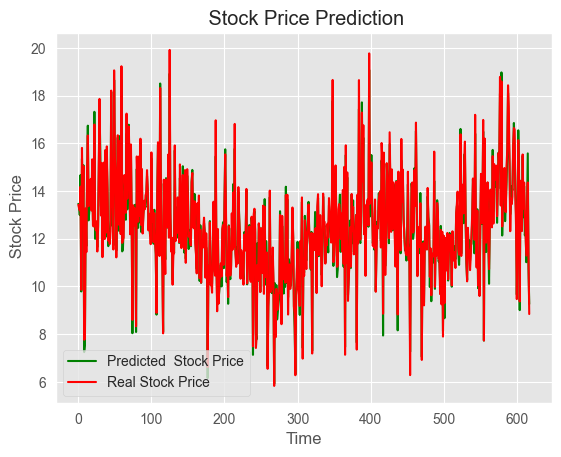

In [82]:
# predict
stock_predictor.predict()

# test_part

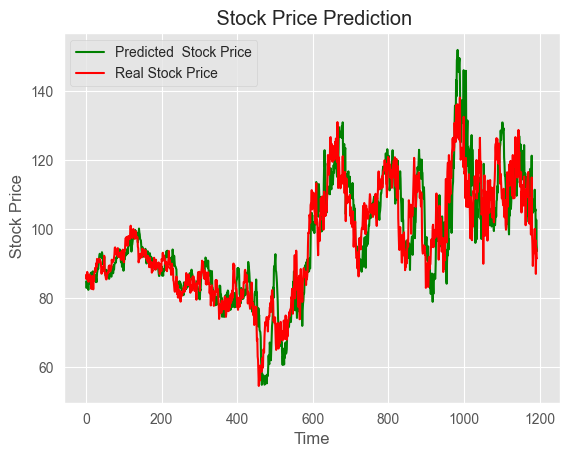

38/38 [==============================] - 0s 3ms/step - loss: 0.0067 - mse: 0.0067 - mae: 0.0615  


[0.006717715412378311, 0.006717715412378311, 0.061492133885622025]

In [83]:
stock_predictor.predict_others('./data/data.csv')